# Overview
- [Link to Video](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3)
- Multi-Layer Perceptron began in [this paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- they built a word-level language model (vocabulary size of 17k)
    - each word gets a 30-dimensional feature vector (30 dimension embedding)
- the embeddings begin randomly, but as we train we are tuning these embeddings
    - goal is to bring words with similar meanings into a very similar part of the space
    - multiple dimensions to show how items can be similar
    - embedding matrix is shared among all of the inputs (rather than each input getting a unique embedding matrix)
- loss was log-likelihood calculation like before
- intuition here is that we use the embedding space as a way to transfer knowledge to new situations
    - embedding space sizes then have a trade-off (don't want it to match the wrong situation, or to never find the correlations)
- the biggest computation happens at the end (linear layer)
    - 1 neuron for each vocabulary exists there, each of which is fully connected to the last hidden layer
    - huge amount of parameters lie here

In [211]:
# dependencies
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Building Data
- we read in from our same corpus from last time
- note, we are only reading the first 5 instances here to make our first experiments fast
- our `context = context[1:] + [ix]` is important because it shows how we are keeping the window a constant size
    - each data is at most of size 3, and each time we gain a character, we also remove one
    - the way this is coded, we can also easily adjust blocksize (it's filled with 0s if the word is too small)
- note the shape at the end:
    - (32, 3)
        - 32, as we have 32 blocks of 3 from our first 5 words
        - 3 is for the block_size we had

In [212]:
words = open('../building_makemore/names.txt', "r").read().splitlines()
chars = sorted(list(set(''.join(words))))
char_to_index = {s:i+1 for i,s in enumerate(chars)}
char_to_index["."] = 0
index_to_char = {i:s for s,i in char_to_index.items()}

# build dataset
block_size = 3 #how many characters does it take to predict the next one
X, Y = [], []
for w in words[:5]:
    context = [0] * block_size
    print("\n"+w)
    for ch in w + '.':
        ix = char_to_index[ch]
        X.append(context)
        Y.append(ix)
        print("".join(index_to_char[i] for i in context), "-->", index_to_char[ix])
        context = context[1:] + [ix] # context gains a character and loses one to keep the length the same

# why tensor & not Tensor?
X = torch.tensor(X)    
Y = torch.tensor(Y)    
X.shape, X.dtype, Y.shape, Y.dtype



emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .

olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .

ava
... --> a
..a --> v
.av --> a
ava --> .

isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .

sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

# Building Embedding Later
- we are going to instantiate our embedding layer randomly
    - we are choosing dimensions (27,2)
        - 27 for each of the possible vocabulary
        - 2 arbitrarily (each of our vocab has 2 dimensional embedding)
- below shows us exploring different ways to index into the tensor
    - C[X] is the most important, we are indexing into the torch on a multi-dimensional level
        - here, we are getting the embeddings (C) for every single corresponding row in X
    - as a toy example:
```
C = [[2, 2],  # C[0]
     [1, 1]]  # C[1]

X = [[1],     # Index for C[1]
     [1],     # Index for C[1]
     [0],     # Index for C[1]
     [1],     # Index for C[1]
     [1]]     # Index for C[1]

C[X] = 
C[X] = [
  [[1, 1]], //= C[X[0]] = C[1]
  [[1, 1]], //= C[X[1]] = C[1]
  [[2, 2]], //= C[X[2]] = C[0]
  [[1, 1]], //= C[X[3]] = C[1]
  [[1, 1]]  //= C[X[3]] = C[1]
]
``` 

In [213]:
# building our embedding matrix
C = torch.randn((27, 2)) # 2 dimensional embedding for every char

# indexing into our embedding matrix for an entire row
C[5]
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # does the same thing, but C[5] is much faster in pytorch

# index with list
C[[1,2,3]]

# index with tensor of ints
C[torch.tensor([1,2,3])]

# get the same index multiple times
C[[5,5,5]]

# index multi-dimensional
C[X]
C[X].shape
# (32, 3, 2)

print(X[13, 2])
C[1] == C[X][13,2] # here we are getting X[13,2] and then indexing that into C => X[13,2] = 1 => C[1]

emb = C[X] # this is how we'll represent the first interaction in our model (input meeting embedding layer)

tensor(1)


# PyTorch Indexing Examples
- cat() shows how we can concatenate tensors together
    - note that unbind() achieves the same thing as making sure we combine the tensors along 1 dimension
- storage() shows that in Pytorch all tensors are laid out as 1-dimensional
    - when we use view(), we are rearranging the tensor -- we can pick any dimensions we want provided they still hold all our data
        - eg: (18,1) can be (6, 3) (9,2)
- in short, simply doing the view() can effectively adjust our dimensions without needing to do more calculations
    - cat() is the most inefficient because it needs to use the most intermediary memory

[link to helpful blog post](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [214]:
# 0-2 because the block size is 3
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape# (all the examples, 0th-2nd index, all of the channels)

# unbind is a torch item that will do this >> [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]
torch.cat(torch.unbind(emb, 1), 1).shape

#proof (when batch size == 3)
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape == torch.cat(torch.unbind(emb, 1), 1).shape

a = torch.arange(18)
print(a)
print(a.view(18, 1))
a.storage()

emb.view(32, 6)  == torch.cat(torch.unbind(emb, 1), 1)#this is the same as a concatonation
# output is an element wise comparison
# note cat is far more inefficient because we create intermediary versions to handle the torch

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17]])


tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

# building our simple model
- we are going to have 2 hidden layers here with weights and biases
- our input dimension to the weights is 6 ==> 3 inputs x 2 embedding layers
    - we arbitrarily choose 100 as our hidden layer size
    - our biases need to match the neuron size
- we then use tanh() as our activation layer, making sure our cross-multiplication with W1 has the right dimensions thanks to emb.view()
    - we are converting our (32, 3, 2) here into a (32, 6) for easy multiplication with W1 (6, 100)
- we set our W2 input dimension to match the hidden layer (100) and then output 27 to match our vocabulary size
    - note again, our biases need to match
- we compute the logits by multiplying our activations from the first layer (h) by W2 (dimensions already match so no need for view())
- we take our logits to e^x then we normalize these to create probabilities (soft max normalization)
- by indexing into the 32 examples where the right values are (Y), we get how close we were to the right answers
    - prob[[1...32], Y] => prob1[Y], prob2[Y], prob3[Y], etc.
    - if we mean all of these, we will find one possible loss function for our model

In [215]:
W1 = torch.randn((6, 100)) # 3 inputs with 2 embeddings each (6), 100 is arbitrary
b1 = torch.randn(100) # match neurons
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) #emb.shape[0] == 32 here (-1 means pytorch needs to infer)

W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape # (32, 27) => probabilites for every letter for all 32 examples

counts = logits.exp() # here we take our logits to e^x
prob = counts / counts.sum(1, keepdim=True) # 
-prob[torch.arange(32), Y].log().mean() # approximates the loss
# F.cross_entropy(logits, Y) we will use cross-entropy

tensor(17.4946)

# 

# Edge Cases with Softmax
- with very high values, we can see our gradients get messed up
    - example: [100, -3, 0, 10]
- If we instead subtract the largest value of the tensor in and then take the softmax, we will no longer have the concern
    - this is what pytorch does under the hood


In [216]:
# why cross-entropy
logits = torch.tensor([100000, -3, 0, -10000])
counts = logits.exp()
prob = counts / counts.sum()
print(prob)

logits = torch.tensor([100000, -3, 0, -10000]) - 100000
counts = logits.exp()
prob = counts / counts.sum()
print(prob)

tensor([nan, 0., 0., 0.])
tensor([1., 0., 0., 0.])


# Finding the Learning Rate
- Learing Rate is the proportion of the gradient we adjust our weights or biases by
- finding the right one is a matter or running experiments
- below, we use torch.linspace() to create 1000 gradations of different powers we can try to run
    - generally 1 is too high (leads to failure to learn)
    - by plotting the exponents, we can see where the loss is minimized and then use that
- generally the learning rate shouldn't stay the same throughout the run (we adjust this in what's called a learning rate scheduler)
    - the basic intuition is that at the beginning we want large changes to the gradients, but then as we progress we want smaller ones to avoid overwriting critical information

In [217]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
emb = C[X]

# initializing our weights & biases
W1 = torch.randn((6, 100), generator=g) # 3 inputs with 2 embeddings each (6), 100 is arbitrary
b1 = torch.randn(100, generator=g) # match neurons
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# putting all of our parameters into a single tensor
parameters = [C, W1, b1, W2, b2]
print(f"total params: {sum(p.nelement() for p in parameters)}")


for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []


for i in range(1000):
    minibatch = torch.randint(0, X.shape[0], (32,))

    emb = C[X[minibatch]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

total params: 3481


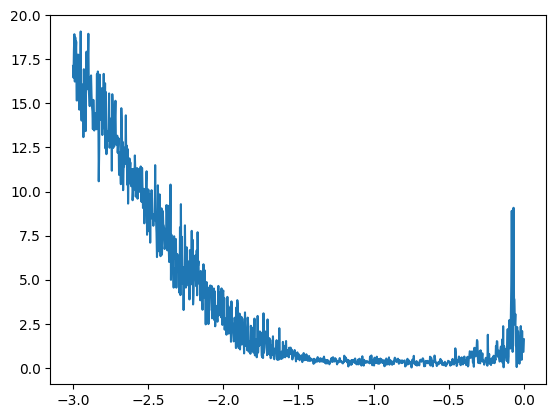

In [218]:
plt.plot(lri, lossi)
# the best one then is 0.1

In [219]:
# loss on the whole model at the end
emb = C[X] 
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

0.8611006140708923

In [220]:
# Why are we not able to predict all of the right values all of the time?
# take the example:
# ... => E
# vs ... => A
# vs ... => O
# In our set, all are possible outcomes for the same input (so it's never fully deterministic)

logits.max(1).indices == Y


tensor([False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

# Data Set Split
- when we train a lot, we risk overfitting to the training data
- this is problematic as the goal of the model is to successfully handle examples outside the training set
- to avoid this, we split our data into 3 pieces (training, validation, testing)
    - split roughly (80, 10, 10)
- We use validation as a signal of how well the model generalizes, so we can adjust our hyperparameters
- our testing set is what we use to publish success

In [221]:
def build_dataset(data):
    block_size = 3 #how many characters does it take to predict the next one
    X, Y = [], []
    for w in data:
        context = [0] * block_size
        for ch in w + '.':
            ix = char_to_index[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # context gains a character and loses one to keep the length the same
    X = torch.tensor(X)    
    Y = torch.tensor(Y)    
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*(len(words)))
n2 = int(0.9*(len(words)))

Xtr, Ytr = build_dataset(words[:n1])
Xvalid, Yvalid = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

# Batch Sizes
- to move more efficiently through the training runs, we also break up our data into batches
- the idea is that with smaller amounts of data going through the model, we can have each run go faster and thus give more iterations to improve
- the tradeoff is that a mini-batch's loss is not the loss on the entire corpus
    - consequently, we expect to see loss bounce around due to the difference between the loss on the batch and the loss on the general corpus
- the larger your batch, generally the fewer steps you need

In [222]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
emb = C[X]

# initializing our weights & biases
W1 = torch.randn((6, 100), generator=g) # 3 inputs with 2 embeddings each (6), 100 is arbitrary
b1 = torch.randn(100, generator=g) # match neurons
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# putting all of our parameters into a single tensor
parameters = [C, W1, b1, W2, b2]
print(f"total params: {sum(p.nelement() for p in parameters)}")


for p in parameters:
    p.requires_grad = True

for _ in range(50000):
    minibatch = torch.randint(0, Xtr.shape[0], (32,)) 

    emb = C[Xtr[minibatch]] # setting up BTC [32, 3, 2]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[minibatch])
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

# evaluate on dev
emb = C[Xvalid] # setting up BTC [32, 3, 2]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yvalid)
print(loss.item())

total params: 3481
2.7456789016723633
2.377218723297119


# Building a Bigger Model
- we are now going to expand the hidden layer in an attempt to improve the model's loss
- Before we were at ~100, so here we simply adjust the dimension of the weights and biases to match 300
- because we have more weights, we also want to increase the number of steps we take to train the model
    - the complexity of fitting the weights increases with more weights. To increase the odds we fit correctly, we add more steps

In [223]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)

# initializing our weights & biases
W1 = torch.randn((6, 300), generator=g) # 3 inputs with 2 embeddings each (6), 100 is arbitrary
b1 = torch.randn(300, generator=g) # match neurons
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

# putting all of our parameters into a single tensor
parameters = [C, W1, b1, W2, b2]
print(f"total params: {sum(p.nelement() for p in parameters)}")


for p in parameters:
    p.requires_grad = True

stepi = []
lossi = []
validlossi = []
last_valid_lossi = 4

# adjust steps, and make bigger batch size

for i in range(50000):
    minibatch = torch.randint(0, Xtr.shape[0], (32,)) # not a great way though, as we may never see all of the dataset (or see some more than others)
    # gradient direction is less valuable as we are only training on portions, but much better to have an approximate gradient and make more steps than to have an exact gradient and take fewer steps
    # basically we trade off batch size for steps

    emb = C[Xtr[minibatch]] # setting up BTC [32, 3, 2]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[minibatch])
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.01 * p.grad

    if i % 10000 == 0 and i != 0:
            emb = C[Xvalid] # setting up BTC [32, 3, 2]
            h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, Yvalid)
            last_valid_lossi = loss.item()
    
    # track stats
    validlossi.append(last_valid_lossi)
    stepi.append(i)
    lossi.append(loss.item())

# evaluate on dev
emb = C[Xvalid] # setting up BTC [32, 3, 2]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yvalid)
print(loss.item())

total params: 10281
2.4199726581573486


# Analyzing Embeddings + Loss
- Looking at our loss graph:
    - we can see that the loss has flat-lined, and specifically that more training steps do not appear to be reducing the loss
    - this suggests that our bottle neck is likely elsewhere in the model
- Looking at the scatterplot, we can see that the different letters have been grouped based on usage by the network (signalling that the weights are no longer random post-training)
    - specifically, we can see that the vowels are grouped together, and letters that are rarely used (like q or .) are quite distinct from the rest.
    - this makes sense, as the embeddings are basically inputs, so when we have a very unique input, we expect a very unique embedding

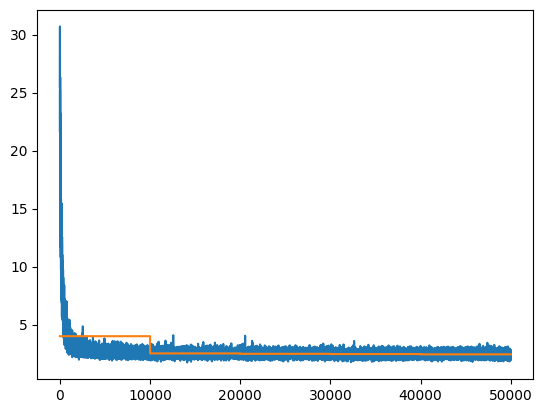

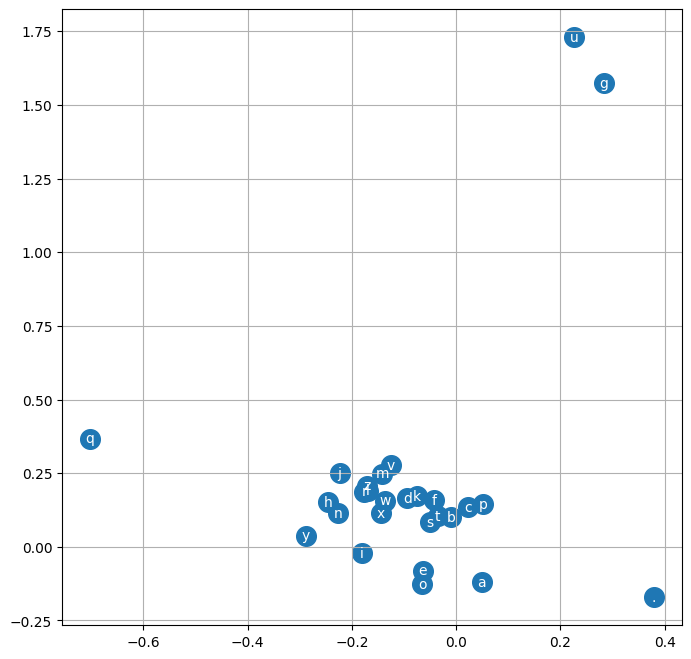

In [224]:
plt.plot(stepi, lossi)
plt.plot(stepi, validlossi)

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), index_to_char[i], ha="center", va="center", color="white")
plt.grid("minor")

# Expanding the Embedding Layer
- We saw that the embedding layer was likely the bottleneck because the hidden layer got much bigger and the loss did not improve
- We will go from 2 to 10 dimensions, and this requires we adjust the rest of our model to handle larger tensors
- We adjust the size of our weight1 tensors so that they can handle 3 inputs x 10 dimensions (so a matrix of size 30)
- Running this we see that we get Karpathy's 2.17 loss

In [225]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)

# initializing our weights & biases
W1 = torch.randn((30, 200), generator=g) # 3 inputs with 10 embeddings each (30), 100 is arbitrary
b1 = torch.randn(200, generator=g) # match neurons
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

# putting all of our parameters into a single tensor
parameters = [C, W1, b1, W2, b2]
print(f"total params: {sum(p.nelement() for p in parameters)}")


for p in parameters:
    p.requires_grad = True

stepi = []
lossi = []

# adjust steps, and make bigger batch size

for i in range(200000):
    minibatch = torch.randint(0, Xtr.shape[0], (32,)) # not a great way though, as we may never see all of the dataset (or see some more than others)
    # gradient direction is less valuable as we are only training on portions, but much better to have an approximate gradient and make more steps than to have an exact gradient and take fewer steps
    # basically we trade off batch size for steps

    emb = C[Xtr[minibatch]] # setting up BTC [32, 3, 2]
    h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[minibatch])
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

# evaluate on dev
emb = C[Xvalid] # setting up BTC [32, 3, 2]
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yvalid)
print(loss.item())

# andrej got 2.1701 validation (beat this!)

total params: 11897
2.0793213844299316
2.159499168395996


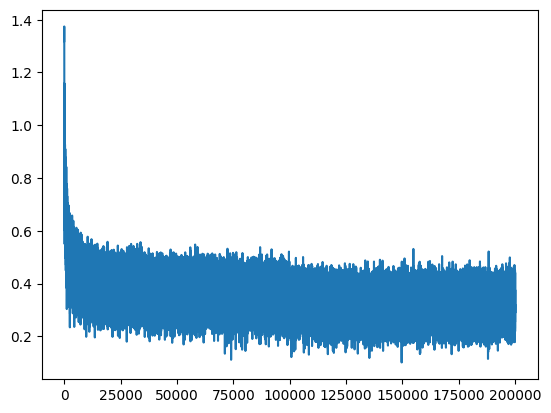

In [226]:
plt.plot(stepi, lossi)
# in production you set hyperparameters and run many different experiments

# Trying to Beat Andrej's Score
- Andrej ends the video asking us to beat his loss, which scores ~2.17 on the validation set after the training run is complete
- I tried this initially by expanding the network significantly (400 dimension hidden layer, 20 embeddings per token), but its loss wasn't getting lower
- I set my dimensions similar to Karpathy's (3 inputs, 10 embedding dimensions per input, 200 hidden dimensions) but adjusted the learning rate schedule
- I found that the later I moved the learning rate drop, the lower my overall loss was
- this suggests that the model was being undertrained early on
- final score I got was 2.11

In [227]:
block_size = 3
embeddings_per_token = 10
hidden_dim = 200


def build_dataset(data):
    X, Y = [], []
    for w in data:
        context = [0] * block_size
        for ch in w + '.':
            ix = char_to_index[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)    
    Y = torch.tensor(Y)    
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*(len(words)))
n2 = int(0.9*(len(words)))

Xtr, Ytr = build_dataset(words[:n1])
Xvalid, Yvalid = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embeddings_per_token), generator=g)

weightin = Xtr.shape[1] * embeddings_per_token
W1 = torch.randn((weightin, hidden_dim), generator=g) # 400
b1 = torch.randn(hidden_dim, generator=g) # match neurons
W2 = torch.randn((hidden_dim, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"total params: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

stepi = []
lossi = []
validlossi = []
lri = []
last_valid_lossi = 4
# adjust steps, and make bigger batch size

for i in range(300000):
    minibatch = torch.randint(0, Xtr.shape[0], (32,)) # not a great way though, as we may never see all of the dataset (or see some more than others)
    # gradient direction is less valuable as we are only training on portions, but much better to have an approximate gradient and make more steps than to have an exact gradient and take fewer steps
    # basically we trade off batch size for steps

    emb = C[Xtr[minibatch]] # setting up BTC [32, 3, 2]
    h = torch.tanh(emb.view(emb.shape[0], weightin) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[minibatch])
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 300000*.8 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0 and i != 0:
        emb = C[Xvalid] # setting up BTC [32, 3, 2]
        h = torch.tanh(emb.view(emb.shape[0], weightin) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Yvalid)
        last_valid_lossi = loss.item()
    
    # track stats
    validlossi.append(last_valid_lossi)
    stepi.append(i)
    lossi.append(loss.log10().item())
    lri.append(lr)
print(loss.item())

# evaluate on dev
emb = C[Xvalid] # setting up BTC [32, 3, 2]
h = torch.tanh(emb.view(emb.shape[0], weightin) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yvalid)
print(loss.item())

total params: 11897
2.0324249267578125
2.1337037086486816


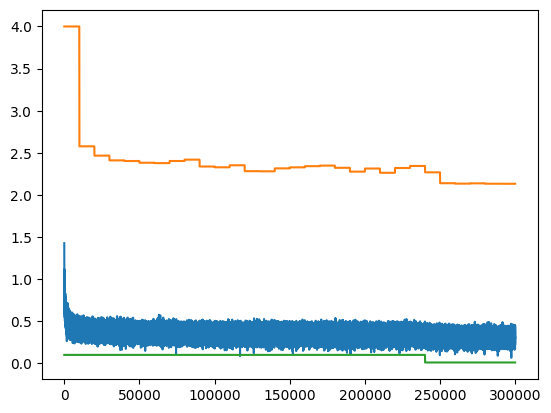

In [228]:
plt.plot(stepi, lossi)
plt.plot(stepi, validlossi)
plt.plot(stepi, lri)